# Q-learning with function approximation - egocentric environment

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/NiloufarRazmi/RL_Olfaction/HEAD?labpath=FuncApprox%2FFuncApprox_ego.ipynb)

## The task

<img src='./img/task.png' width="400">

## Initialization

In [1]:
# Import packages
import numpy as np
from tqdm import tqdm
import pandas as pd

In [2]:
# Load custom functions
from utils import Params
from environment_ego import (
    WrappedEnvironment,
    Actions,
    CONTEXTS_LABELS,
    LightCues,
    OdorID,
)
from agent import QLearningFuncApprox, EpsilonGreedy
import plotting

In [3]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Choose the task parameters

In [4]:
# Choose the parameters for the task
params = Params(epsilon=0.1, n_runs=3, numEpisodes=200, alpha=0.025)
params

Params(epsilon=0.1, gamma=0.8, alpha=0.025, jointRep=True, n_runs=3, numEpisodes=200)

## Load the environment and the agent algorithms

In [5]:
# Load the environment
env = WrappedEnvironment(params)

In [6]:
# Manually engineered features, optional
# if `None`, a diagonal matrix of features will be created automatically
features = np.matlib.repmat(
    np.eye(
        len(env.tiles_locations) * len(env.head_angle_space),
        len(env.tiles_locations) * len(env.head_angle_space),
    ),
    len(LightCues) * len(OdorID),
    len(LightCues) * len(OdorID),
)
features = None

In [7]:
# Load the agent algorithms
learner = QLearningFuncApprox(
    learning_rate=params.alpha,
    gamma=params.gamma,
    state_size=env.numStates,
    action_size=env.numActions,
    features_matrix=features,
)
explorer = EpsilonGreedy(epsilon=params.epsilon)

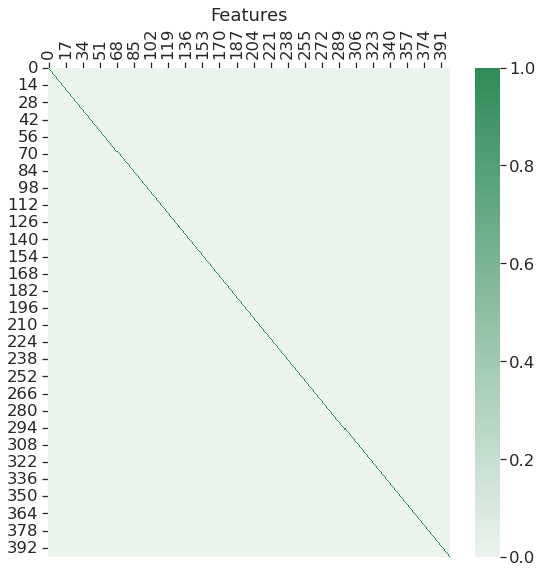

In [8]:
plotting.plot_heatmap(matrix=learner.features, title="Features")

## States and actions meaning

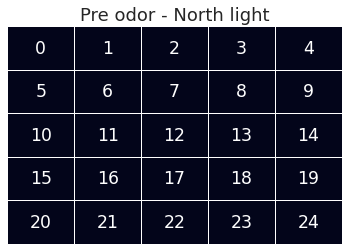

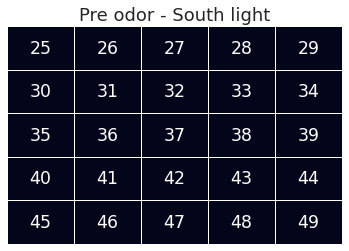

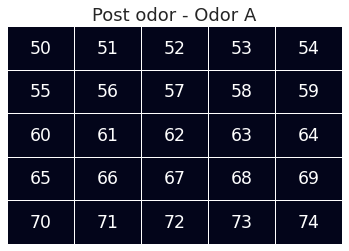

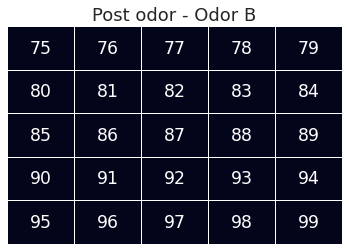

In [9]:
# State space
for idx, label in enumerate(CONTEXTS_LABELS):
    plotting.plot_tiles_locations(
        np.array(list(env.tiles_locations)) + idx * len(env.tiles_locations),
        env.rows,
        env.cols,
        title=label,
    )

### Correspondance between flat states and (internal) composite states

In [10]:
# state = 63
# env.convert_flat_state_to_composite(state)

In [11]:
# env.convert_composite_to_flat_state({"location": 13, "cue": LightCues.North})

### Action meaning

In [12]:
action = 0
Actions(action)

<Actions.FORWARD: 0>

## Main loop

In [13]:
rewards = np.zeros((params.numEpisodes, params.n_runs))
steps = np.zeros((params.numEpisodes, params.n_runs))
episodes = np.arange(params.numEpisodes)
qtables = np.zeros((params.n_runs, *learner.Q_hat_table.shape))
all_states = []
all_actions = []

for run in range(params.n_runs):  # Run several times to account for stochasticity

    learner.reset_Q_hat_table()  # Reset the Q-table between runs

    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{params.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        step_count = 0
        done = False
        total_rewards = 0

        while not done:
            learner.Q_hat_table = learner.Q_hat(learner.weights, learner.features)

            action = explorer.choose_action(
                action_space=env.action_space,
                state=state,
                qtable=learner.Q_hat_table,
            )

            # Record states and actions
            all_states.append(state)
            all_actions.append(Actions(action).name)

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done = env.step(action, state)

            learner.weights[:, action] = learner.update_weights(
                state, action, reward, new_state
            )

            total_rewards += reward
            step_count += 1

            # Our new state is state
            state = new_state

        # explorer.epsilon = explorer.update_epsilon(episode)

        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count
    qtables[run, :, :] = learner.Q_hat_table

## Postprocessing

In [14]:
res = pd.DataFrame(
    data={
        "Episodes": np.tile(episodes, reps=params.n_runs),
        "Rewards": rewards.flatten(),
        "Steps": steps.flatten(),
    }
)
res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
# st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
qtable = qtables.mean(axis=0)  # Average the Q-table between runs

In [15]:
res

,Episodes,Rewards,Steps,cum_rewards
0,0,0.0,105.0,0.0
1,1,10.0,11.0,0.0
2,2,10.0,10.0,10.0
3,3,0.0,28.0,10.0
4,4,10.0,12.0,20.0
...,...,...,...,...
595,195,10.0,7.0,1800.0
596,196,10.0,8.0,1810.0
597,197,10.0,21.0,1810.0
598,198,10.0,15.0,1820.0


In [16]:
# plotting.qtable_directions_map(qtable, env.rows, env.cols)

## Visualization

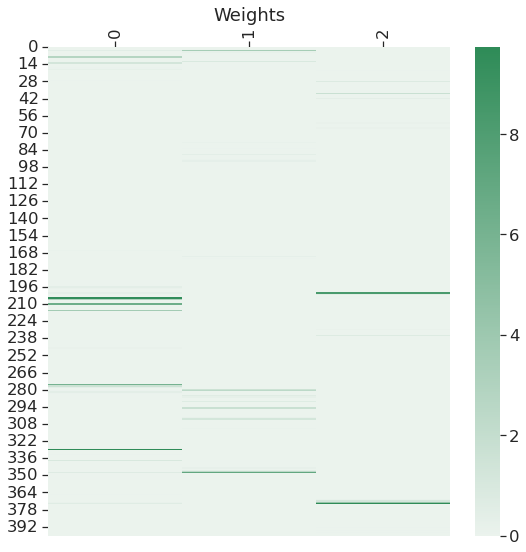

In [17]:
plotting.plot_heatmap(matrix=learner.weights, title="Weights")

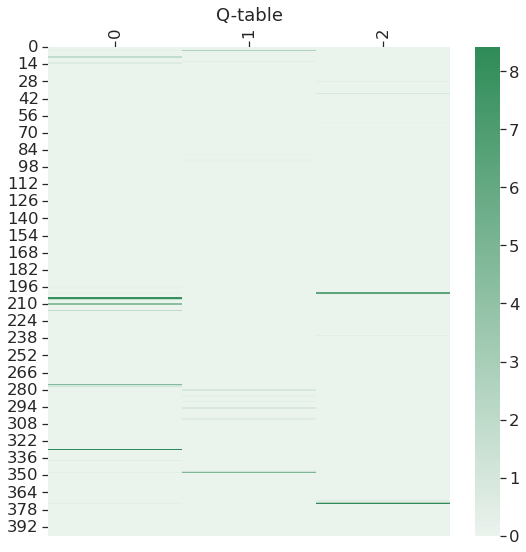

In [18]:
plotting.plot_heatmap(matrix=qtable, title="Q-table")

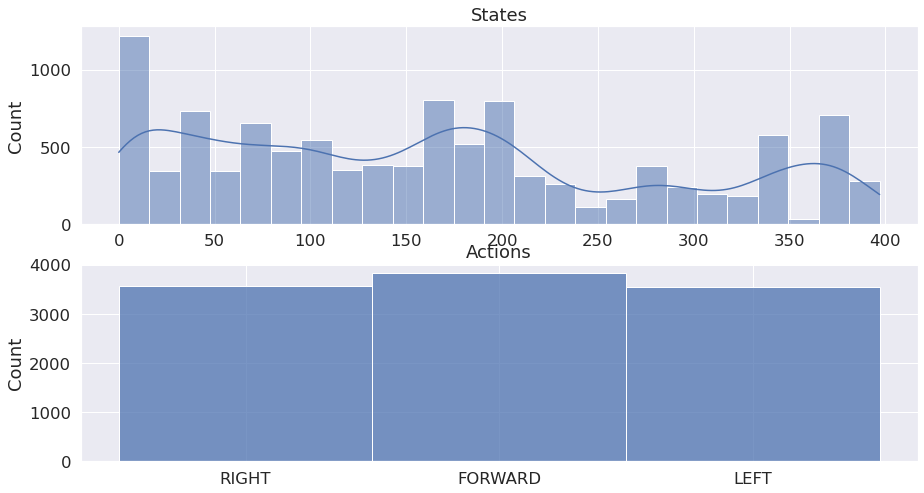

In [19]:
plotting.plot_states_actions_distribution(all_states, all_actions)

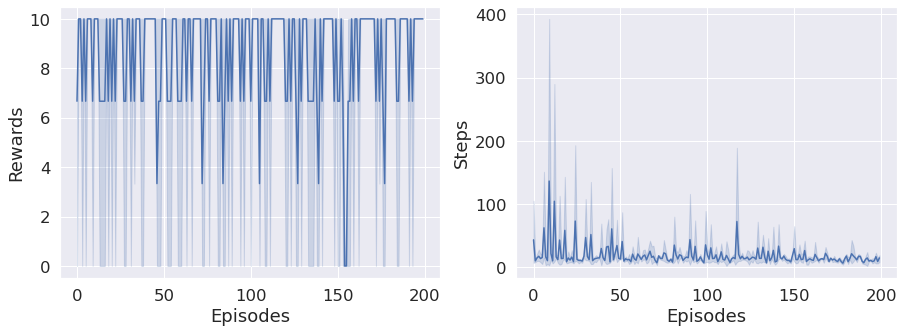

In [20]:
plotting.plot_steps_and_rewards(res)

In [21]:
# plotting.plot_q_values_maps(qtable, env.rows, env.cols, CONTEXTS_LABELS)

In [22]:
# plotting.plot_rotated_q_values_maps(qtable, env.rows, env.cols, CONTEXTS_LABELS)